# About the dataset

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy:
The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts:
A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma:
This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

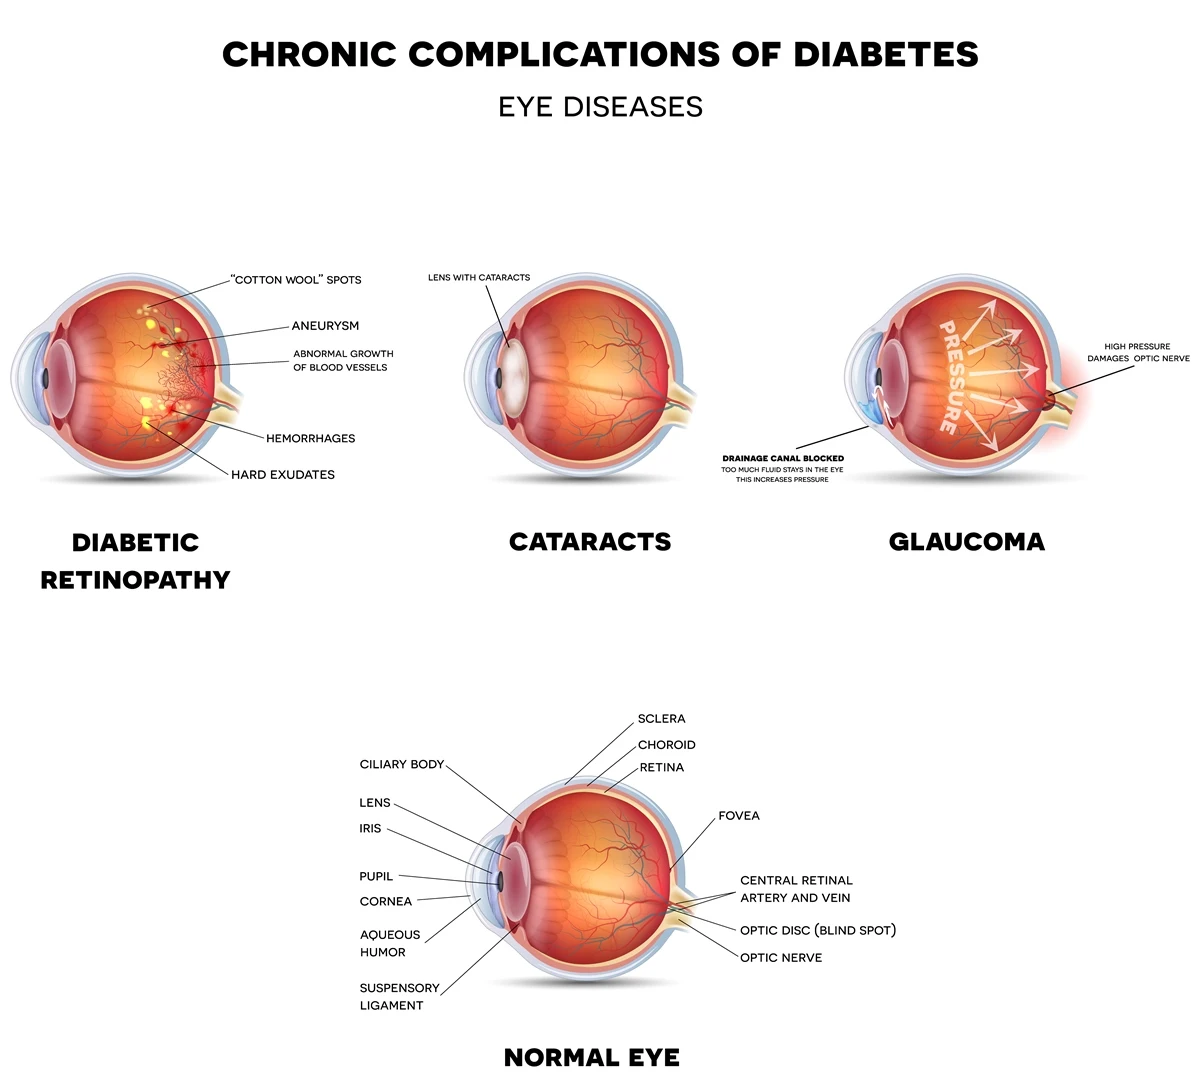

# About this notebook
#### In this notebook i will try to make a **comparison** between building and training a **nerual network from scratch** and using **Transfer learning(pretrained model)**, in terms of **trainig time, ease of creation, accuracy and consistancy**
#### This notebook was intented to be just a self trial to test the results, but i saw that it might help others so i tried to add insights and some references that might help

## Importing libraries

In [244]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')
!pip install visualkeras
import visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/





     |████████████████████████████████| 989 kB 13.0 MB/s 






# TensorFlow pipeline
We will create a dataset pipeline from our data using tensorflow dataset api

TensorFlow has a dataset api that supports writing descriptive and efficient input pipelines. a common pattern is to
- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

[For more information](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [67]:
# generating dataset from directory

# Generating train dataset
data = tf.keras.utils.image_dataset_from_directory(directory = '/content/eye-diseases-classification/dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)


Found 4217 files belonging to 4 classes.


## Displaying data distribution

In [68]:
labels = np.concatenate([y for x,y in data], axis=0)

In [69]:
values = pd.value_counts(labels)
values = values.sort_index()

In [70]:
values

0    1038
1    1098
2    1007
3    1074
dtype: int64

### Checking labels

In [71]:
# getting class names
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = diabetic_retinopathy, 2 = glaucoma, 3 = normal, 

### The data is well distributed among the classes and is balanced

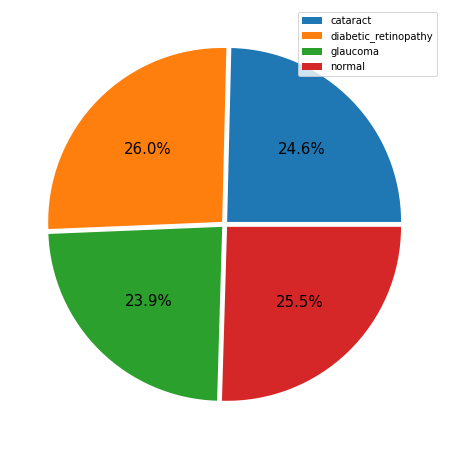

In [72]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02,0.02,0.02, 0.02], textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

## Getting a data generator to explore the data

In [73]:
data_iterator = data.as_numpy_iterator()

In [74]:
batch = data_iterator.next()

### Each batch contains 64 images, each image is 224x224

In [75]:
batch[0].shape

(64, 224, 224, 3)

## Displaying some images

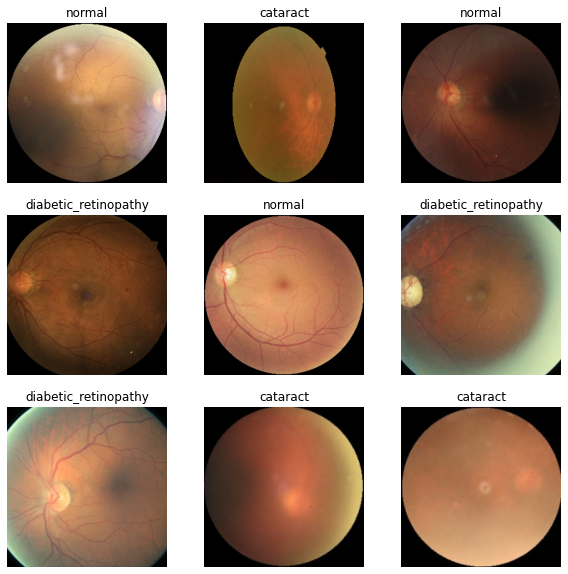

In [76]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

-----------
# Preprocessing images

## Standardize the data

In [77]:
data = data.map(lambda x, y: (x/255, y))

In [78]:
sample = data.as_numpy_iterator().next()

In [79]:
print(sample[0].min())
print(sample[0].max())

0.0

1.0


## Spliting the data

In [80]:
print("Total number of batchs = ",len(data))

Total number of batchs =  66


In [81]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [82]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [83]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}, # test batch = {len(test)}")
len(train) + len(val) + len(test)

# train batchs = 47, # validate batchs = 13, # test batch = 6


66

## Preparing test set

In [173]:
test_iter = test.as_numpy_iterator()

In [174]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [193]:
y_true = test_set['labels']

------------
# CNN from scratch

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [85]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

### **Here i tried to make the nerual network as deep as i can with keeping the training time and the memory in mind, so we will train it from the scratch and see where we can achieve by this**

In [234]:
def create_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

In [235]:
model = create_baselineCNN()

Model: "sequential_9"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_63 (Conv2D)          (None, 224, 224, 64)      1792      

                                                                 

 conv2d_64 (Conv2D)          (None, 224, 224, 64)      36928     

                                                                 

 batch_normalization_59 (Bat  (None, 224, 224, 64)     256       

 chNormalization)                                                

                                                                 

 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 64)     0         

 g2D)                                                            

                                                                 

 dropout_51 (Dropout)        (None, 112, 112, 64)      0         

                                                                 

 conv2d_65 (Conv2D)          (None, 11

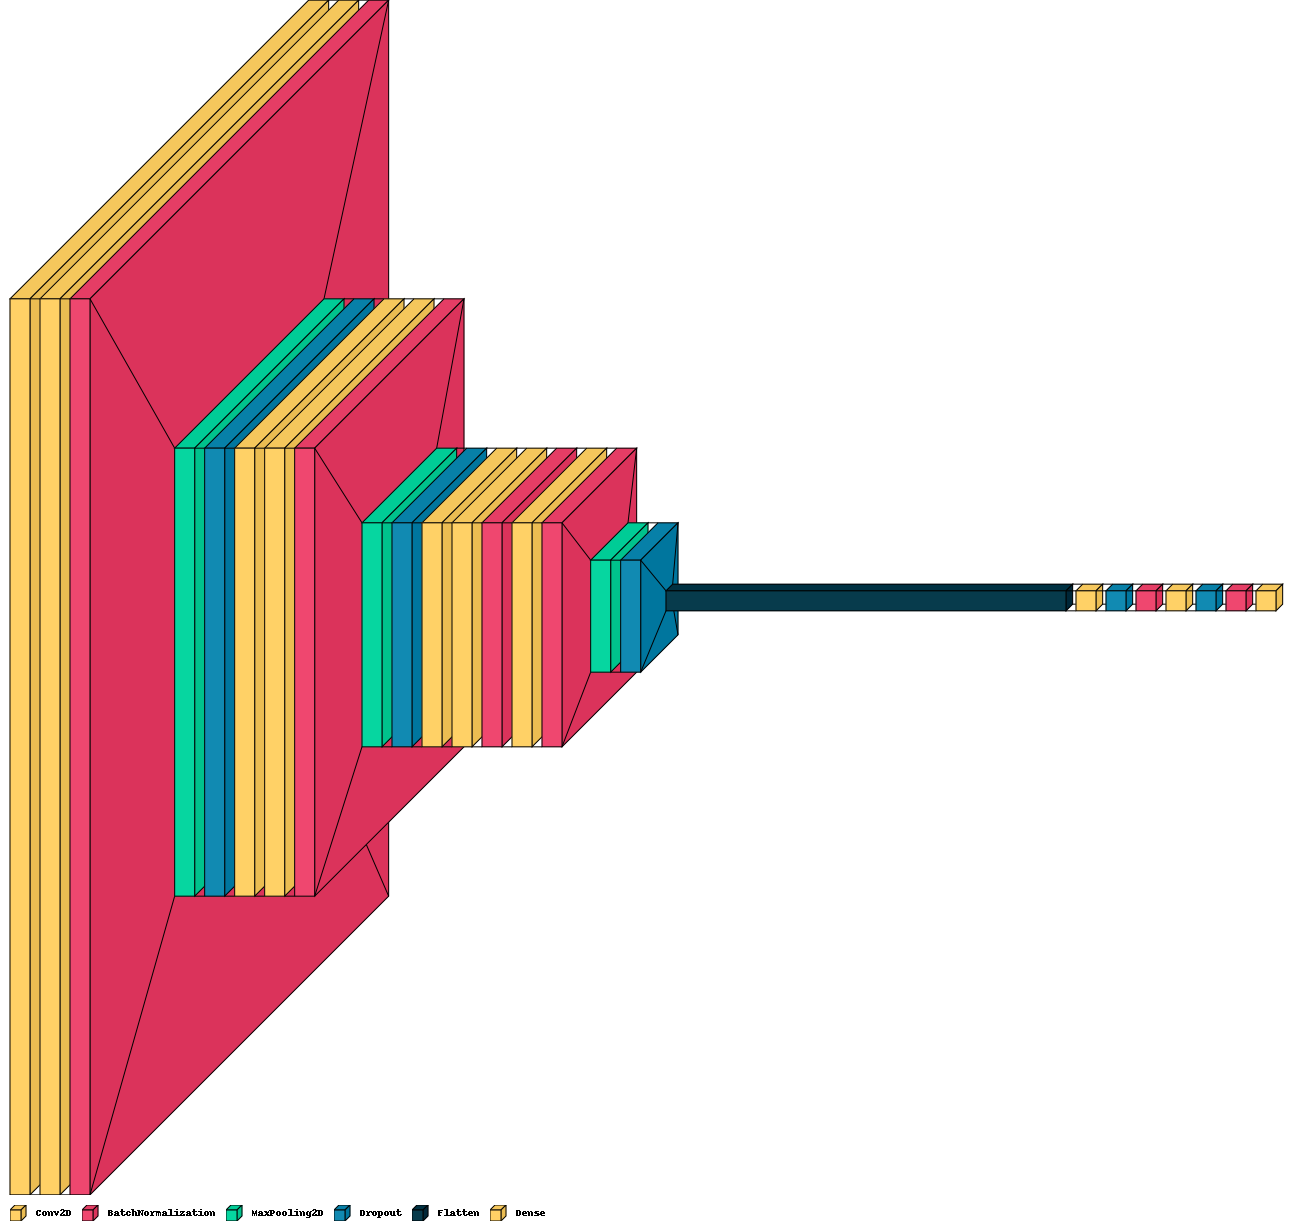

In [245]:
model.summary()

visualkeras.layered_view(model,legend=True)

## Model training
#### **We will train the Nerual network with 60 epochs and give it an earlystop callback if the accuracy didn't improve much for 20 epochs**

In [237]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=20,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 60,
    callbacks=[early_stop],
)

Epoch 1/60

47/47 [==============================] - 71s 1s/step - loss: 1.3010 - accuracy: 0.4448 - val_loss: 2.1961 - val_accuracy: 0.2668

Epoch 2/60

47/47 [==============================] - 65s 1s/step - loss: 0.9731 - accuracy: 0.5575 - val_loss: 4.2651 - val_accuracy: 0.2548

Epoch 3/60

47/47 [==============================] - 64s 1s/step - loss: 0.8129 - accuracy: 0.6546 - val_loss: 7.0836 - val_accuracy: 0.2512

Epoch 4/60

47/47 [==============================] - 65s 1s/step - loss: 0.7209 - accuracy: 0.7094 - val_loss: 7.0175 - val_accuracy: 0.2608

Epoch 5/60

47/47 [==============================] - 65s 1s/step - loss: 0.6556 - accuracy: 0.7301 - val_loss: 7.4071 - val_accuracy: 0.2476

Epoch 6/60

47/47 [==============================] - 64s 1s/step - loss: 0.6178 - accuracy: 0.7304 - val_loss: 8.0807 - val_accuracy: 0.2620

Epoch 7/60

47/47 [==============================] - 63s 1s/step - loss: 0.5613 - accuracy: 0.7703 - val_loss: 2.5567 - val_accuracy: 0.3450

Epoch 

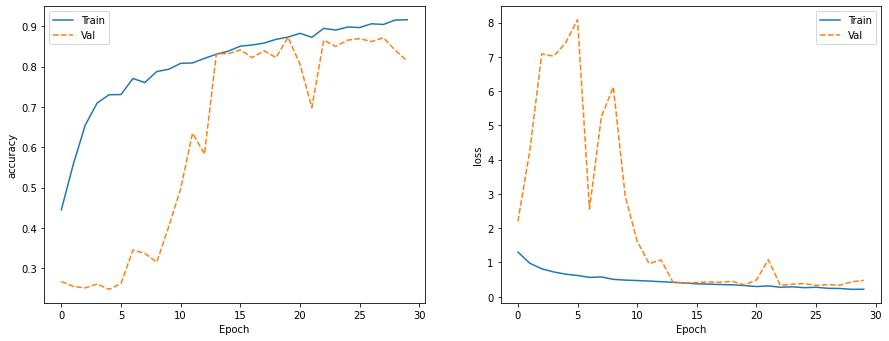

In [238]:
plot_his(history)

## Evaluating the model on the test set

In [239]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

12/12 [==============================] - 6s 250ms/step


In [242]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support



            cataract       0.82      0.87      0.84        98

diabetic_retinopathy       1.00      1.00      1.00        95

            glaucoma       0.92      0.68      0.78        95

              normal       0.74      0.89      0.81        89



            accuracy                           0.86       377

           macro avg       0.87      0.86      0.86       377

        weighted avg       0.87      0.86      0.86       377




Text(0.5, 1.0, 'Confusion Matrix')

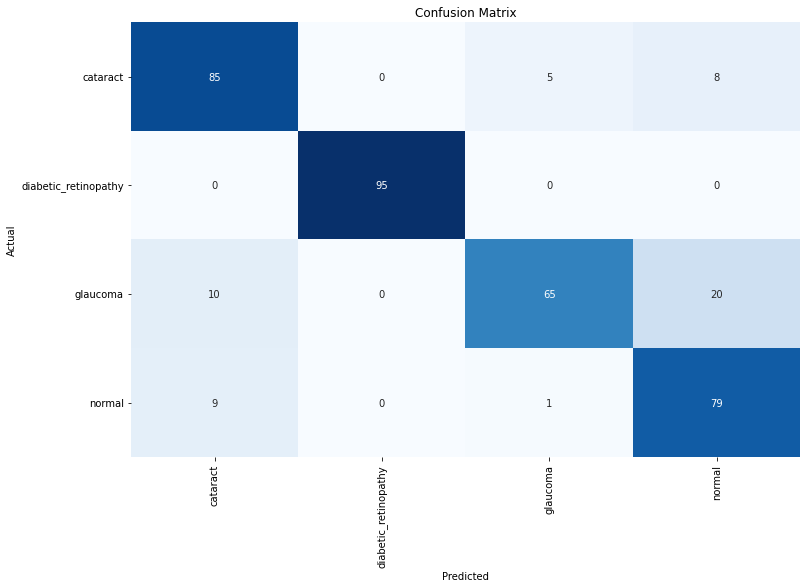

In [240]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## **Insights**
- The model acheived 86% accuracy and f1-score for the test set
- The model has stopped earlier with only 30 epochs of training due to early stopping, and to notice if it would continue this would result a clear overfitting
- Each Eboch took about 63 seconds to execute
- Although it achieved a good accuracy but validation loss wasn't consistant at all and has a lot of fluctuations

-----------
# Transfer Learning (Pretrained Model)
#### **Here i will try to use a pretraind model, finetune it to fit our data, you can read [more about transfer learning here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)**
#### **I used [EfficientNet](https://paperswithcode.com/method/efficientnet) pretrained model, because the data it was trained on is different from our data, i made the top level layers trainable to allow it to train, fit and adapt with our data**

In [90]:
def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    effnet.trainable=False
    
    for layer in effnet.layers[83:]:
      layer.trainable=True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(4, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [91]:
model = make_model()

## Train the Model

In [92]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 50,
    callbacks=[early_stop],
)

Epoch 1/50

47/47 [==============================] - 67s 1s/step - loss: 19.0712 - accuracy: 0.6144 - val_loss: 23.8212 - val_accuracy: 0.2608

Epoch 2/50

47/47 [==============================] - 49s 988ms/step - loss: 13.6643 - accuracy: 0.7543 - val_loss: 12.9307 - val_accuracy: 0.2933

Epoch 3/50

47/47 [==============================] - 50s 1s/step - loss: 10.5703 - accuracy: 0.8052 - val_loss: 10.0963 - val_accuracy: 0.3702

Epoch 4/50

47/47 [==============================] - 51s 1s/step - loss: 8.3634 - accuracy: 0.8248 - val_loss: 8.1085 - val_accuracy: 0.4123

Epoch 5/50

47/47 [==============================] - 49s 1s/step - loss: 6.6561 - accuracy: 0.8481 - val_loss: 6.4073 - val_accuracy: 0.5877

Epoch 6/50

47/47 [==============================] - 49s 995ms/step - loss: 5.3298 - accuracy: 0.8574 - val_loss: 5.0450 - val_accuracy: 0.7067

Epoch 7/50

47/47 [==============================] - 49s 997ms/step - loss: 4.2670 - accuracy: 0.8777 - val_loss: 4.0055 - val_accuracy:

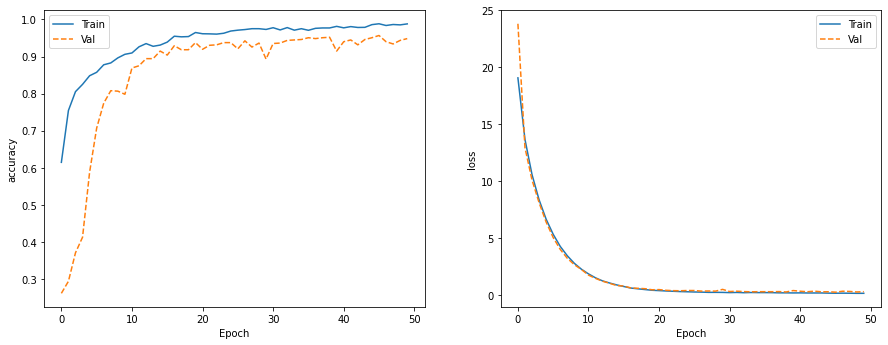

In [93]:
plot_his(history)

## Evaluating the model on test set

In [200]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

12/12 [==============================] - 1s 115ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support



            cataract       0.95      0.96      0.95        98

diabetic_retinopathy       0.99      1.00      0.99        95

            glaucoma       0.87      0.92      0.89        95

              normal       0.91      0.84      0.88        89



            accuracy                           0.93       377

           macro avg       0.93      0.93      0.93       377

        weighted avg       0.93      0.93      0.93       377




Text(0.5, 1.0, 'Confusion Matrix')

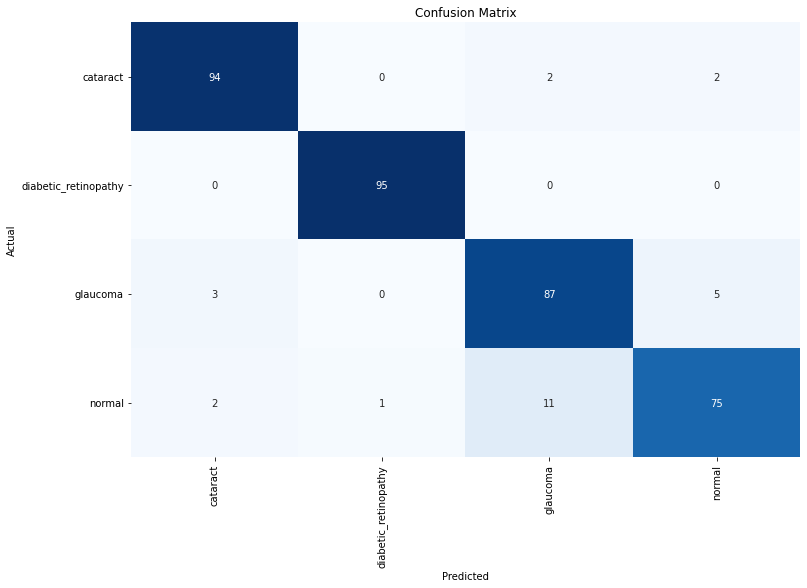

In [207]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

## **Insights**
- The model acheived 93% accuracy and f1-score on the test set
- The training has run for 50 epochs and did not stop by early stopping, although noticing the history plot i don't think it could achieve any higher
- Each Epoch took about 50 sec to execute 
- The validation loss curve looks very smooth and has no fluctuations

# Conclusion
It's very intersting how transfer learning can improve and satisfy our goals with higher accuracy, consistant and faster
- With pretraind model We achieved 93% with 7% improvment from our own Neural network 86%
- The training phase was more consistant and faster in the pretraind model
- Maybe the Neural network i built wasn't the best and could be improved a lot, but you can see how easy and efficient you can use a pretrained model without the headaches of building you own layer by layer and trying to tune it as much as you can and you may not end with better result or close to as the pretrained one

So consider from now on to benfit from the power of Transfer learning and give it a try before trying to build your own one, it may save you a lot.